In [1]:
# PyTorch와 시각화 도구 설치
!pip install torch torchvision torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import shutil
import imageio
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
from itertools import islice
from torch.autograd import Variable
from IPython.display import Image, display

### 2-1. 심층 신경망 구현을 위한 nn.Module

파이토치의 `nn.Module`은 심층 신경망의 각 층(Layer) 구성을 쉽게할 수 있도록 도와줌


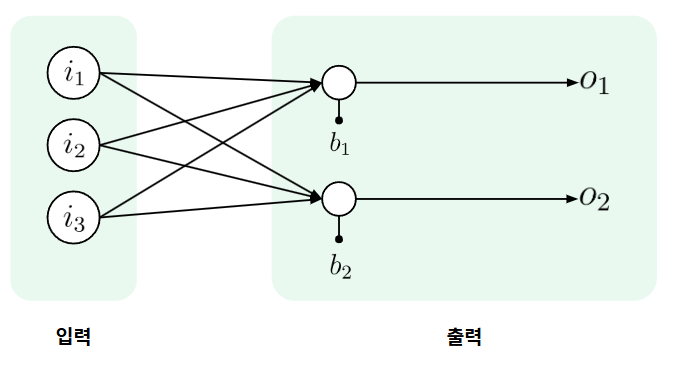

In [3]:
class LinearModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

In [4]:
model = LinearModule(3, 2)
x = torch.randn(10, 3)
print(x)
print()

output = model(x)
print(output)

tensor([[ 1.1290,  0.9584, -0.4332],
        [-1.4276,  0.1969, -1.1179],
        [ 0.6865, -0.0466,  1.4740],
        [ 0.3625, -1.6724, -1.9064],
        [-0.6574,  0.6839,  0.3167],
        [ 1.5305,  1.6110, -0.2962],
        [-1.3738,  0.7478,  0.0091],
        [ 0.8719, -0.1424, -0.3663],
        [ 0.3847,  0.6197, -0.0104],
        [-0.5493,  0.8149,  0.4044]])

tensor([[-6.2492e-01,  2.3879e-01],
        [ 8.7784e-01, -9.1885e-01],
        [-1.5237e+00,  1.7324e-01],
        [ 2.1756e-06, -6.1841e-02],
        [-1.3059e-01, -5.2326e-01],
        [-7.7588e-01,  3.9837e-01],
        [ 3.9924e-01, -8.6546e-01],
        [-7.3189e-01,  1.7424e-01],
        [-5.1512e-01, -6.3516e-02],
        [-2.0454e-01, -4.7589e-01]], grad_fn=<AddmmBackward0>)


## 2-2. XOR 논리게이트 예측 문제 실습

XOR 게이트에서 `A`와 `B` 두개의 입력에 대한 출력 `Y`를 예측하는 모델을 구현

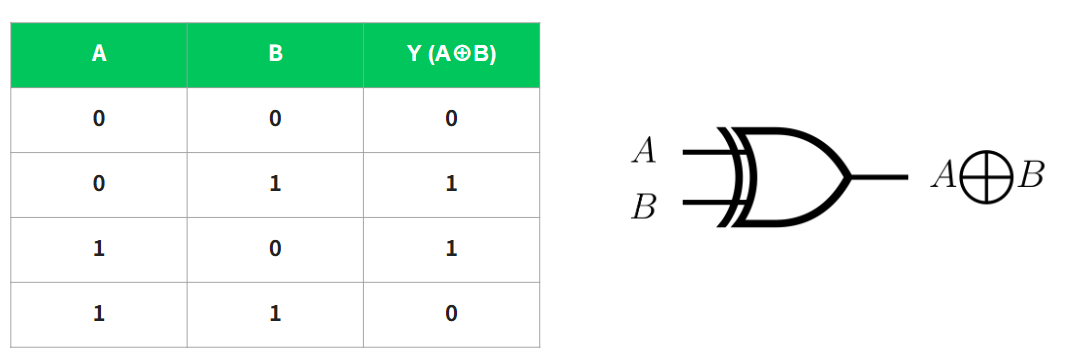

In [5]:
# XOR 연산을 위한 신경망 모델 정의
class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        self.layer1 = nn.Linear(2, 2)  # 입력 2개, 출력 2개
        self.layer2 = nn.Linear(2, 1)  # 입력 2개, 출력 1개
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 정의
x_data = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32).to(device)
y_data = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32).to(device)

# 모델 초기화
model = XORModel().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 50000

In [7]:
# 모델 학습
losses: list[float] = []

for epoch in range(num_epochs + 1):
    # Forward pass
    outputs = model(x_data)
    loss = criterion(outputs, y_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [0/50000], Loss: 0.7094
Epoch [1000/50000], Loss: 0.6932
Epoch [2000/50000], Loss: 0.6932
Epoch [3000/50000], Loss: 0.6931
Epoch [4000/50000], Loss: 0.6930
Epoch [5000/50000], Loss: 0.6929
Epoch [6000/50000], Loss: 0.6925
Epoch [7000/50000], Loss: 0.6913
Epoch [8000/50000], Loss: 0.6829
Epoch [9000/50000], Loss: 0.6003
Epoch [10000/50000], Loss: 0.4491
Epoch [11000/50000], Loss: 0.3943
Epoch [12000/50000], Loss: 0.3756
Epoch [13000/50000], Loss: 0.3670
Epoch [14000/50000], Loss: 0.3621
Epoch [15000/50000], Loss: 0.3591
Epoch [16000/50000], Loss: 0.3570
Epoch [17000/50000], Loss: 0.3555
Epoch [18000/50000], Loss: 0.3543
Epoch [19000/50000], Loss: 0.3534
Epoch [20000/50000], Loss: 0.3527
Epoch [21000/50000], Loss: 0.3521
Epoch [22000/50000], Loss: 0.3516
Epoch [23000/50000], Loss: 0.3512
Epoch [24000/50000], Loss: 0.3509
Epoch [25000/50000], Loss: 0.3506
Epoch [26000/50000], Loss: 0.3503
Epoch [27000/50000], Loss: 0.3501
Epoch [28000/50000], Loss: 0.3499
Epoch [29000/50000], Loss: 

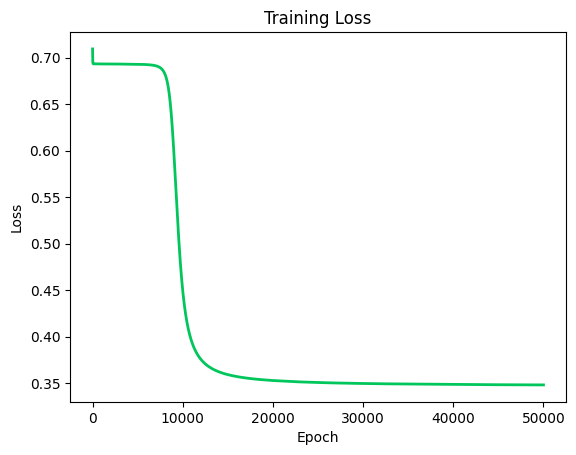

In [8]:
# Loss 시각화
plt.plot(losses, linewidth=2, color="#01c65b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [9]:
# 모델 테스트
with torch.no_grad():
    test = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32).to(device)
    predicted = model(test)
    print(predicted)

tensor([[0.0016],
        [0.4993],
        [0.9986],
        [0.5006]], device='cuda:0')


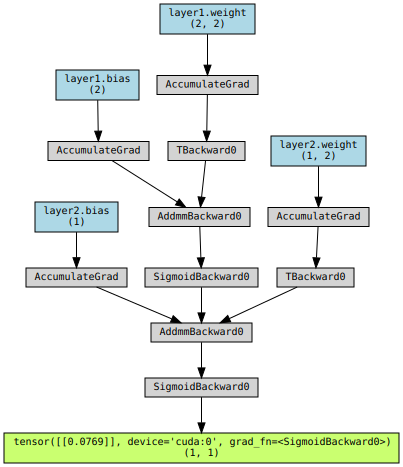

In [11]:
x = torch.randn(1, 2).to(device)
y = model(x)
make_dot(y, params={**dict(model.named_parameters()), y: y})

## 2-3. MNIST 문제 실습

0~9까지 총 10개의 28x28 크기의 손글씨 이미지를 예측하는 MNIST 문제를 풀어보며, 분류 문제를 딥러닝을 통해 해결하는 과정을 이해해봅시다.

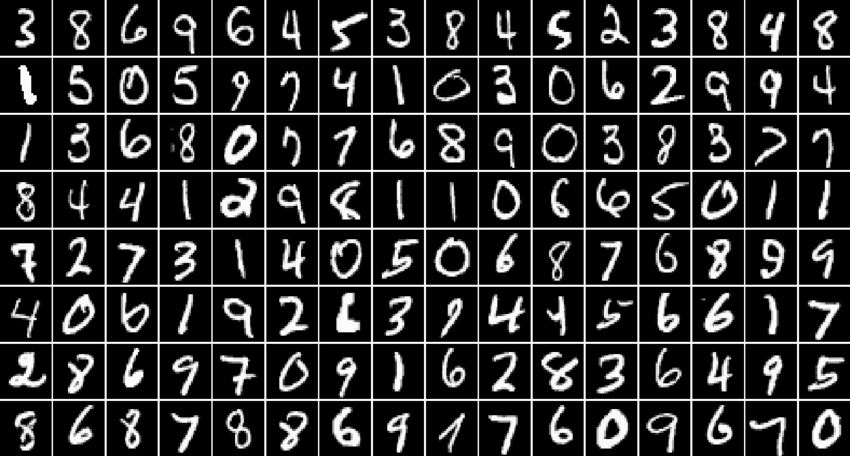

In [12]:
input_size = 784  # 이미지 사이즈 = (너비: 28, 높이: 28) => 28 * 28 = 784 픽셀 해상도
hidden_size = 500 # 은닉 레이어 숫자
num_classes = 10  # 숫자 0 ~ 9까지 총 10가지 종류의 클래스 선별 태스크
num_epochs = 5    # 학습에 사용할 세대 수
batch_size = 100  # 매 학습 사이클의 입력 배치 크기
lr = 1e-3         # 학습에서 사용할 학습 진척도

In [13]:
train_data = dsets.MNIST(root = "./data", train = True, transform = transforms.ToTensor(), download = True)
test_data = dsets.MNIST(root = "./data", train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]


In [14]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(input_size, hidden_size, num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### 2-3-1. 모델 학습

In [16]:
def save_weights_bias_as_images(net: Net, epoch: int, step: int, folder: str) -> torch.NoneType:
    for layer_idx, layer in enumerate(net.children()):
        if isinstance(layer, nn.Linear):
            # 가중치(weight) 시각화
            weights = layer.weight.data.cpu().numpy()
            plt.imshow(weights, cmap="viridis")
            plt.title(f"Layer: {layer_idx} (Weights) - Epoch: {epoch:02}, Step: {step:02}")
            plt.colorbar()
            plt.savefig(f"{folder}/weights_{layer_idx:02}_epoch_{epoch:02}_step_{step:02}.png")
            plt.close()

            # 편향(bias) 시각화
            bias = layer.bias.data.cpu().numpy()
            plt.plot(bias, linewidth=2, color="#01c65b")
            plt.title(f"Layer: {layer_idx:02} (Bias) - Epoch: {epoch:02}, Step: {step:02}")
            plt.savefig(f"{folder}/bias_{layer_idx:02}_epoch_{epoch:02}_step_{step:02}.png")
            plt.close()

In [17]:
gif_frame_image_folder = "weight_bias_images"
if os.path.exists(gif_frame_image_folder):
    shutil.rmtree(gif_frame_image_folder)
os.makedirs(gif_frame_image_folder)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(islice(train_loader, 20)):
        images = Variable(images.view(-1, 28 * 28)).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        save_weights_bias_as_images(net, epoch, i, gif_frame_image_folder)

        if (i+1) % 10 == 0:
            print("Epoch [%d/%d], Step [%d/%d], Loss: %.4f"
                  %(epoch+1, num_epochs, i+1, 20, loss.data))

Epoch [1/5], Step [10/20], Loss: 1.4727
Epoch [1/5], Step [20/20], Loss: 0.8151
Epoch [2/5], Step [10/20], Loss: 0.4569
Epoch [2/5], Step [20/20], Loss: 0.6495
Epoch [3/5], Step [10/20], Loss: 0.4315
Epoch [3/5], Step [20/20], Loss: 0.3962
Epoch [4/5], Step [10/20], Loss: 0.3633
Epoch [4/5], Step [20/20], Loss: 0.5905
Epoch [5/5], Step [10/20], Loss: 0.4168
Epoch [5/5], Step [20/20], Loss: 0.2797


In [18]:
def create_gif(image_folder: str, gif_name: str, fps=30, loop=0):
    images: list[str] = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith(".png"):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=fps, loop=loop)

create_gif("weight_bias_images", "training_progress.gif")
display(Image(filename="training_progress.gif"))

Output hidden; open in https://colab.research.google.com to view.

### 2-3-2. 모델 평가

In [19]:
correct = 0
total = 0
for images, labels in test_loader:
  images = Variable(images.view(-1, 28 * 28)).to(device)
  labels = labels.to(device)

  output = net(images)
  _, predicted = torch.max(output, 1)
  correct += (predicted == labels).sum()
  total += labels.size(0)

print("Accuracy of the model: %.3f %%" %((100*correct)/(total+1)))

Accuracy of the model: 90.491 %


### 2-3-3. 모델 결과 보기

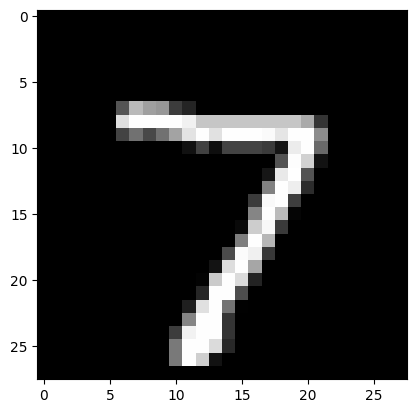

label=tensor(7)
pred=tensor([7], device='cuda:0')


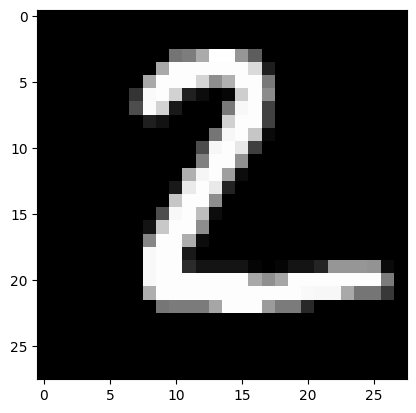

label=tensor(2)
pred=tensor([2], device='cuda:0')


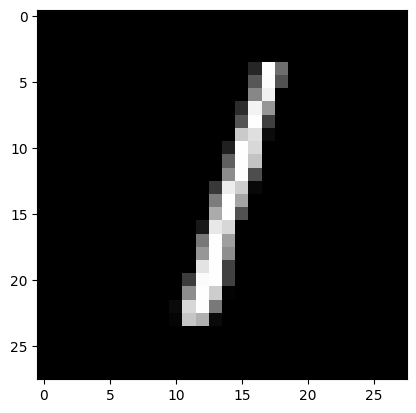

label=tensor(1)
pred=tensor([1], device='cuda:0')


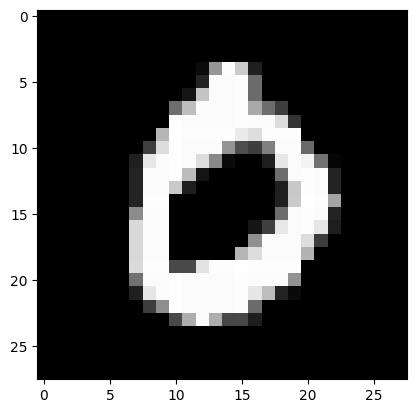

label=tensor(0)
pred=tensor([0], device='cuda:0')


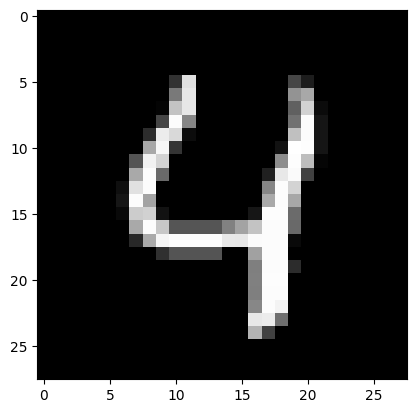

label=tensor(4)
pred=tensor([4], device='cuda:0')


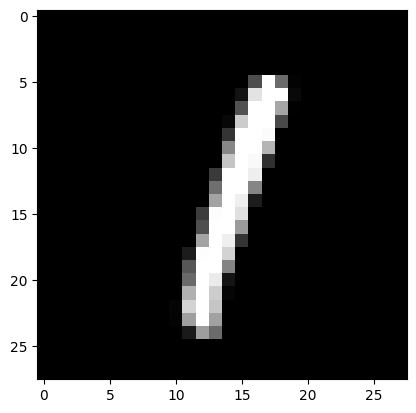

label=tensor(1)
pred=tensor([1], device='cuda:0')


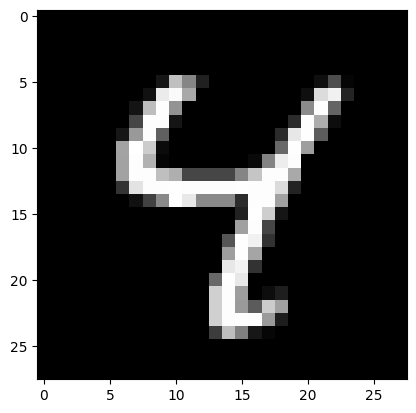

label=tensor(4)
pred=tensor([4], device='cuda:0')


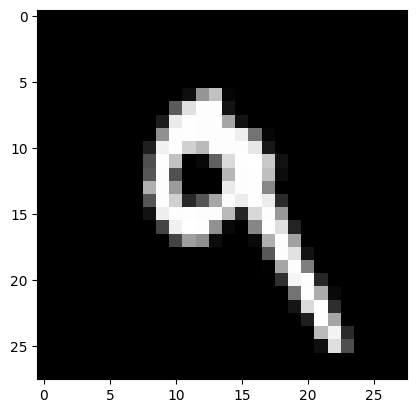

label=tensor(9)
pred=tensor([9], device='cuda:0')


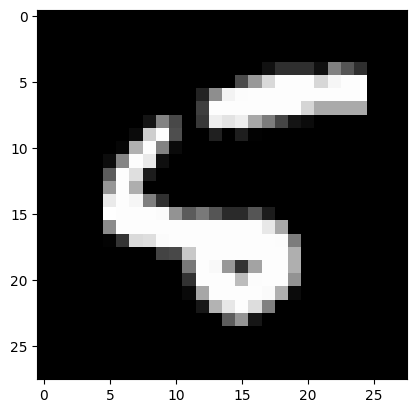

label=tensor(5)
pred=tensor([6], device='cuda:0')


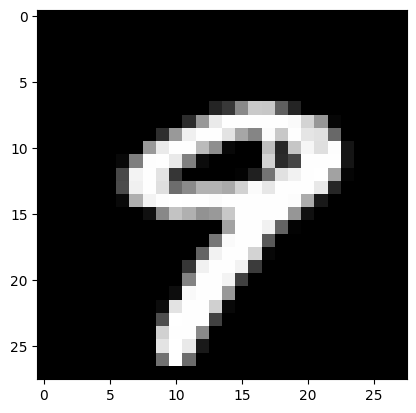

label=tensor(9)
pred=tensor([9], device='cuda:0')


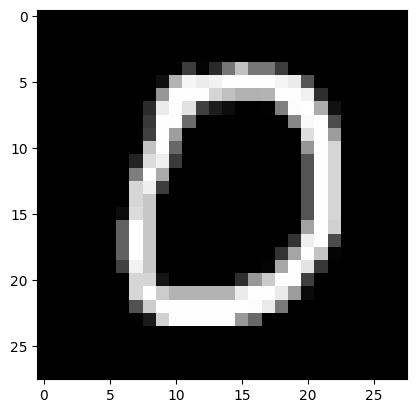

label=tensor(0)
pred=tensor([0], device='cuda:0')


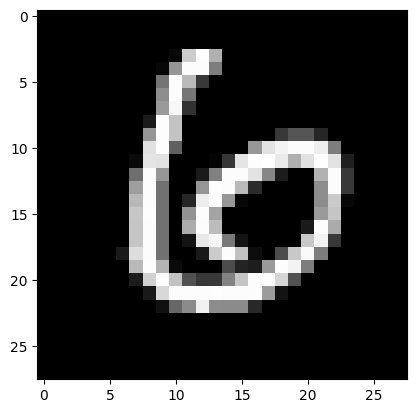

label=tensor(6)
pred=tensor([6], device='cuda:0')


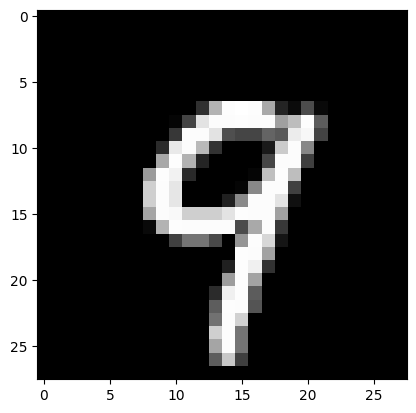

label=tensor(9)
pred=tensor([9], device='cuda:0')


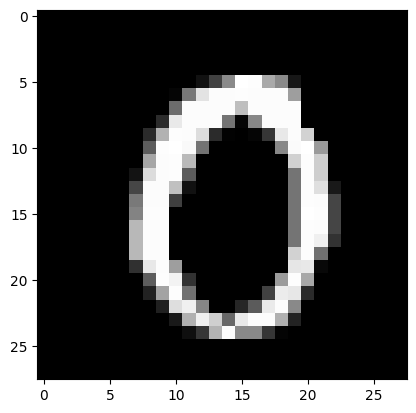

label=tensor(0)
pred=tensor([0], device='cuda:0')


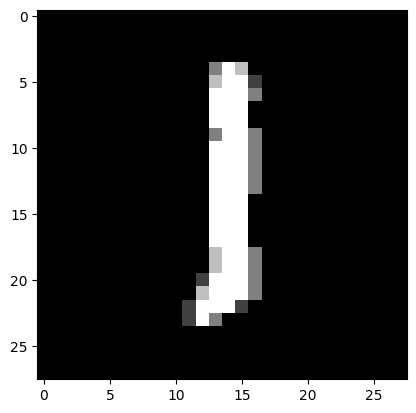

label=tensor(1)
pred=tensor([1], device='cuda:0')


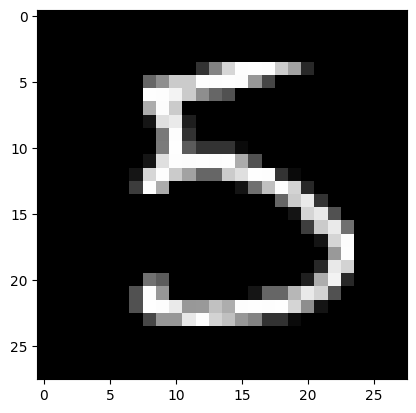

label=tensor(5)
pred=tensor([5], device='cuda:0')


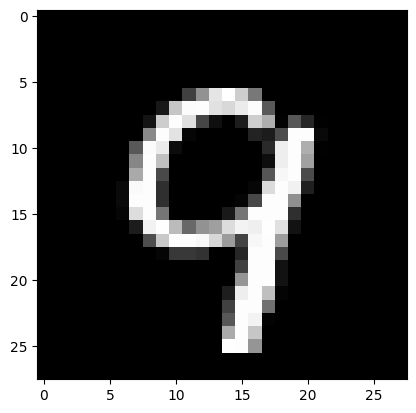

label=tensor(9)
pred=tensor([9], device='cuda:0')


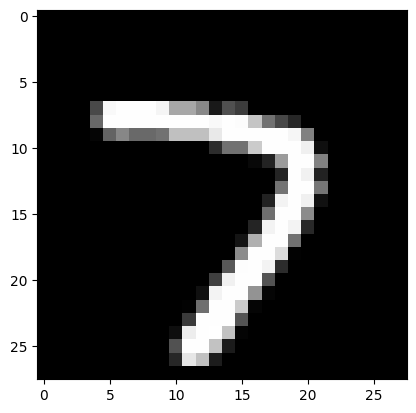

label=tensor(7)
pred=tensor([7], device='cuda:0')


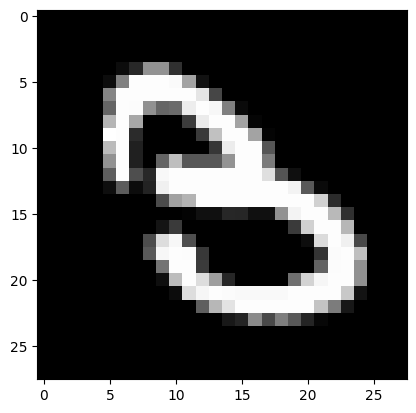

label=tensor(3)
pred=tensor([3], device='cuda:0')


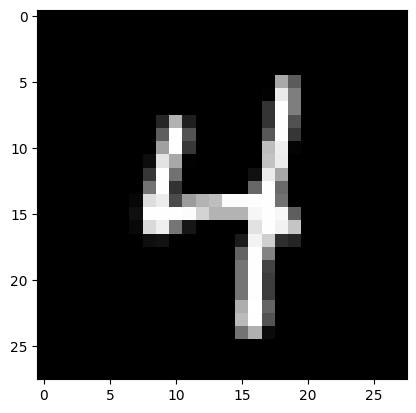

label=tensor(4)
pred=tensor([4], device='cuda:0')


In [20]:
images, labels = next(iter(test_loader))
for image, label in islice(zip(images, labels), 20):
    _, pred = torch.max(net(Variable(image.view(-1, 28 * 28).to(device))), 1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.show()

    print(f"{label=}")
    print(f"{pred=}")

### 2-4. CrossEntropy Loss 이해

`CrossEntropy Loss`는 모델이 예측한 클래스 확률과 실제 정답 사이의 차이를 측정하여, 예측이 정답에 가까울수록 손실이 작아지게 합니다. 이 예제에서는 예측 확률이 다양한 경우에 대해 손실 값을 확인하고, 예측 분포에 따라 손실 값이 어떻게 달라지는지 시각화하여 CrossEntropy Loss의 역할을 살펴봅니다.

In [21]:
# CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()

# 예제 1: 정답 클래스가 3인 경우의 손실 계산
# 예측 확률 분포가 고르게 분포되어 있을 때 (불확실한 예측)
predictions = torch.tensor([[0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 1.2404, 0.5544]])
target = torch.LongTensor([3])
loss = loss_function(predictions, target)
print("예제 1 - 손실 값:", loss.item())

예제 1 - 손실 값: 2.0085251331329346


In [22]:
# 예제 2: 특정 클래스(3)에 높은 확률을 부여한 경우의 손실 계산
# 정답 클래스에 더 높은 확률을 예측한 경우
predictions = torch.Tensor([[3e-5, 5e-3, 1e-6, 0.9204, 2e-3, 3e-4, 5e-4, 5e-5, 0.176, 5e-4]])
loss = loss_function(predictions, target)
print("예제 2 - 손실 값:", loss.item())

예제 2 - 손실 값: 1.5401395559310913


In [23]:
# 예제 3: 정답 클래스 확률이 매우 높은 경우의 손실 계산
# 정답 클래스 3에 확실하게 높은 확률을 부여한 경우
predictions = torch.Tensor([[3e-8, 5e-5, 1e-6, 2.4204, 2e-5, 3e-5, 5e-4, 5e-5, 6e-4, 5e-4]])
loss = loss_function(predictions, target)
print("예제 3 - 손실 값:", loss.item())

예제 3 - 손실 값: 0.5878590941429138


### 2-4-1. CrossEntropy Loss와 예측 분포 시각화

아래는 예측 분포가 변화할 때 `CrossEntropy Loss`가 어떻게 변하는지 보여주는 시각화입니다. 정답 클래스에 높은 확률을 부여할수록 손실이 감소합니다.

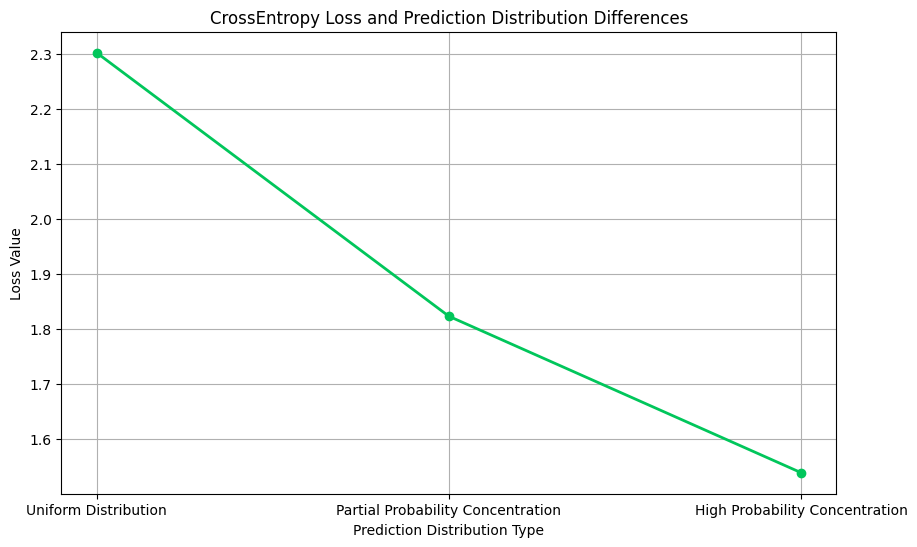

In [24]:
# 여러 분포 설정 및 손실 계산
pred_distributions = [
    torch.tensor([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]),  # 모든 클래스 동일 확률
    torch.tensor([[0.05, 0.05, 0.05, 0.6, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]),  # 정답 클래스에 높은 확률
    torch.tensor([[1e-9, 1e-9, 1e-9, 0.9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9]]),  # 정답 클래스에 매우 높은 확률
]
loss_values = [loss_function(pred, target).item() for pred in pred_distributions]

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker="o", color="#01c65b", linewidth=2)
plt.xticks([1, 2, 3], ["Uniform Distribution", "Partial Probability Concentration", "High Probability Concentration"])
plt.title("CrossEntropy Loss and Prediction Distribution Differences")
plt.xlabel("Prediction Distribution Type")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()

### 2-5. XOR 게이트 심층망 구현을 통한 순전파와 역전파 과정 이해

XOR 게이트 문제를 해결하기 위해 신경망을 사용해 순전파와 역전파의 원리를 학습합니다. XOR 문제는 단순한 방식으로는 해결할 수 없는 문제로, 이를 통해 신경망이 복잡한 패턴을 어떻게 학습하는지 이해할 수 있습니다.


In [25]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def relu(x: np.ndarray) -> np.ndarray:
    return x * (x > 0)


def leaky_relu(x: np.ndarray, alpha: float = 0.01) -> np.ndarray:
    return np.where(x > 0, x, alpha * x)


def post_processing(predictions: np.ndarray) -> np.ndarray:
    return np.where(predictions < 0.5, 0, 1)


def display_results(inputs: np.ndarray, predictions: np.ndarray) -> None:
    processed_predictions = post_processing(predictions)
    print("Input (A, B) | Predicted Y")
    print("---------------------------")
    for i in range(inputs.shape[1]):
        print(f"   {inputs[0, i]}, {inputs[1, i]}    |     {processed_predictions[0, i]}")


def initialize_parameters() -> dict[str, np.ndarray]:
    parameters = {
        "W1": np.random.randn(2, 2),  # 가중치 | INPUT(2 units) -> Hidden Layer(2 units)
        "b1": np.zeros((2, 1)),       # 편향 | Hidden Layer(2 units)
        "W2": np.random.randn(1, 2),  # 가중치 | Hidden Layer(2 units) -> Output(1 unit)
        "b2": np.zeros((1, 1))        # 편향 | Output(1 unit)
    }
    return parameters


def compute_loss(Y: np.ndarray, Y_hat: np.ndarray) -> np.ndarray:
    # BCE (Binary Cross Entropy)
    m = Y.shape[0]
    loss = -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m
    return loss


def forward_propagation(
    X: np.ndarray,
    parameters: dict[str, np.ndarray],
) -> tuple[np.ndarray, np.ndarray]:
    # 가중치와 편향 추출
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # 입력층에서 히든레이어까지의 연산
    Z1 = np.dot(W1, X) + b1
    A1 = leaky_relu(Z1)

    # 히든레이어에서 출력층까지의 연산
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    return A1, A2


def backward_propagation(
    parameters: dict[str, np.ndarray],
    A1: np.ndarray,
    A2: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
) -> dict[str, np.ndarray]:
    m = X.shape[1]
    W2 = parameters["W2"]
    dZ2 = (A2 - Y) * A2 * (1 - A2)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * (A1 > 0)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }

    return gradients


def update_parameters(
    parameters: dict[str, np.ndarray],
    grads: dict[str, np.ndarray],
    learning_rate: float = 6.5,
) -> dict[str, np.ndarray]:
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    return parameters


# XOR 문제에 대한 입력과 출력 정의
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
outputs = np.array([0, 1, 1, 0])

# 파라미터 초기화와 순전파 실행
parameters = initialize_parameters()
predicted_outputs = forward_propagation(inputs, parameters)[1]

# 예측 결과 출력
display_results(inputs, predicted_outputs)

Input (A, B) | Predicted Y
---------------------------
   0, 0    |     1
   0, 1    |     1
   1, 0    |     0
   1, 1    |     1


In [26]:
for i in range(200000):
    A1, A2 = forward_propagation(inputs, parameters)
    grads = backward_propagation(parameters, A1, A2, inputs, outputs)
    parameters = update_parameters(parameters, grads)
    loss = compute_loss(outputs, A2)

    if i > 0 and i % 10000 == 0:
        print(f"{i=}, {loss=}")

predicted_outputs = forward_propagation(inputs, parameters)[1]
print(predicted_outputs)
display_results(inputs, predicted_outputs)

i=10000, loss=np.float64(0.6931676341522663)
i=20000, loss=np.float64(0.6931591880935732)
i=30000, loss=np.float64(0.6931543376691858)
i=40000, loss=np.float64(0.693151550412227)
i=50000, loss=np.float64(0.693149946961635)
i=60000, loss=np.float64(0.6931490227644033)
i=70000, loss=np.float64(0.6931484883360892)
i=80000, loss=np.float64(0.6931481775911278)
i=90000, loss=np.float64(0.6931479952426916)
i=100000, loss=np.float64(0.69314788662283)
i=110000, loss=np.float64(0.6931478203672047)
i=120000, loss=np.float64(0.6931477784809521)
i=130000, loss=np.float64(0.6931477506393446)
i=140000, loss=np.float64(0.6931477309180415)
i=150000, loss=np.float64(0.6931477159172209)
i=160000, loss=np.float64(0.6931477036853919)
i=170000, loss=np.float64(0.6931476931019851)
i=180000, loss=np.float64(0.6931476835231458)
i=190000, loss=np.float64(0.6931476745785249)
[[0.49936601 0.50028867 0.49971197 0.50063463]]
Input (A, B) | Predicted Y
---------------------------
   0, 0    |     0
   0, 1    |     

In [27]:
def forward_propagation_for_debuging(X, parameters) -> tuple[np.ndarray, np.ndarray]:
    # 가중치와 편향 추출
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    print(f"{X=}")
    print(f"{W1=}")
    print(f"{b1=}")
    print(f"{W2=}")
    print(f"{b2=}")

    # 입력층에서 히든레이어까지의 연산
    Z1 = np.dot(W1, X) + b1
    print(f"{Z1=}")
    A1 = relu(Z1)
    print(f"{A1=}")

    # 히든레이어에서 출력층까지의 연산
    Z2 = np.dot(W2, A1) + b2
    print(f"{Z2=}")
    A2 = sigmoid(Z2)
    print(f"{A2=}")

    return A1, A2

In [28]:
predicted_outputs = forward_propagation_for_debuging(inputs, parameters)[1]
predicted_outputs

X=array([[0, 0, 1, 1],
       [0, 1, 0, 1]])
W1=array([[-1.34770144,  0.68383038],
       [-0.73048249,  0.01928572]])
b1=array([[-0.82939861],
       [-0.16893823]])
W2=array([[ 0.57495993, -1.25021278]])
b2=array([[0.00012067]])
Z1=array([[-0.82939861, -0.14556823, -2.17710005, -1.49326967],
       [-0.16893823, -0.14965251, -0.89942072, -0.880135  ]])
A1=array([[-0., -0., -0., -0.],
       [-0., -0., -0., -0.]])
Z2=array([[0.00012067, 0.00012067, 0.00012067, 0.00012067]])
A2=array([[0.50003017, 0.50003017, 0.50003017, 0.50003017]])


array([[0.50003017, 0.50003017, 0.50003017, 0.50003017]])